# Example Training for Normalizing Flows

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import random

from data.visu_density import plot_heatmap_2d
from data.plot_samples import plot_samples_2d
from utils.train_utils import sanity_check, train_density_estimation, nll
from normalizingflows.flow_catalog import Made, BatchNorm
from data.data_manager import Dataset

tfd = tfp.distributions
tfb = tfp.bijectors

tf.random.set_seed(1234)

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

tensorflow:  2.8.0
tensorflow-probability:  0.15.0


/home/marcel/Repos/normalizing-flows/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data
First, load the data you want to train the normalizing flow on. Available datasets are various toy data distributions, the datasets POWER, GAS, and MINIBOONE from the UCI machine learning repository, MNIST, and CelebA. This example is on the 2D toy dataset "tum". Note that for 2D toy data the train data is returned already in batches, while the validation and test data is returned unbatched.

In [2]:
dataset_size = 2000  # ony necessary for toy data distributions
batch_size = 800
dataset_name = 'moons'

In [3]:
dataset = Dataset(dataset_name, batch_size=batch_size)
batched_train_data, val_data, test_data = dataset.get_data()

2022-03-25 14:43:10.588971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 14:43:10.601405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 14:43:10.601975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 14:43:10.603334: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

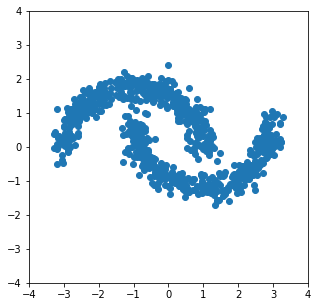

In [4]:
sample_batch = next(iter(batched_train_data))
plot_samples_2d(sample_batch)

## 2. Build the Normalizing Flow
The next step is to build the respective normalizing flow. In this example the Masked Autogregressive Flow (MAF) implementation from Tensorflow is used. The documentation can be found here [1]. Other flows can be imported from "normalizingflows/flow_catalog.py". In Tensorflow several layers of normalizing flows are chained with the "tfb.Chain" function [2]. For flows that use coupling transformations, e.g. Real NVP, Neural Spline Flow, and MAF, it is recommended to use permutation between the layers of the flow. Batch normalization, which is also implemented in the "flow_catalog.py" file, improves the results on high dimensional datasets such as image data. 
The normalzing flow is created by inputting the chained bijector with all layers a base distribution, which is usually a Gaussian distribution, into the "tfd.TransformedDistribution" [3].

[1]: https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow
[2]: https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Chain
[3]: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/TransformedDistribution

In [5]:
hidden_shape = [200, 200]  # hidden shape for MADE network of MAF
layers = 12  # number of layers of the flow

base_dist = tfd.Normal(loc=0.0, scale=1.0)  # specify base distribution

bijectors = []

# Adding BatchNorm corrupts the result!
#bijectors.append(BatchNorm(eps=10e-5, decay=0.95))

for i in range(0, layers):
    bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn = Made(params=2, hidden_units=hidden_shape, activation="relu")))
    bijectors.append(tfb.Permute(permutation=[1, 0]))  # data permutation after layers of MAF

    # add BatchNorm every two layers
    #if (i+1) % int(2) == 0:
    #    bijectors.append(BatchNorm(eps=10e-5, decay=0.95))
    
bijector = tfb.Chain(bijectors=list(reversed(bijectors))[:-1], name='chain_of_maf')

maf = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_dist, sample_shape=[2]),
    bijector=bijector,
)

# initialize flow
samples = maf.sample()

## 3. Train the Normalizing Flow
In this example we train the flow with a polynomial learning rate decay. Afer the training, the checkpoint with the best performance on the validation set is reloaded and tested on the test dataset. Early stopping is used, if the validation loss does not decrease for "delta_stop" epochs.

In [6]:
base_lr = 1e-4
end_lr = 1e-5
max_epochs = int(5e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

In [7]:
# initialize checkpoints
checkpoint_directory = "{}/tmp_{}".format(dataset_name, str(hex(random.getrandbits(32))))
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=maf)

2022-03-25 14:43:12.303063: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


0, train_loss: 5.1588592529296875, val_loss: 4.88593053817749
100, train_loss: 2.8758544921875, val_loss: 2.914166212081909
200, train_loss: 2.7191689014434814, val_loss: 2.806938409805298
300, train_loss: 2.660896062850952, val_loss: 2.759894371032715
400, train_loss: 2.6081438064575195, val_loss: 2.728959321975708
500, train_loss: 2.5610768795013428, val_loss: 2.687317132949829
600, train_loss: 2.5234289169311523, val_loss: 2.6934268474578857
700, train_loss: 2.4930994510650635, val_loss: 2.6620233058929443
800, train_loss: 2.478055238723755, val_loss: 2.6580207347869873
900, train_loss: 2.4600093364715576, val_loss: 2.6887314319610596
1000, train_loss: 2.452874183654785, val_loss: 2.663525342941284
1100, train_loss: 2.450770616531372, val_loss: 2.665825843811035
1200, train_loss: 2.4414358139038086, val_loss: 2.6706655025482178
1300, train_loss: 2.42866587638855, val_loss: 2.683690071105957
1400, train_loss: 2.4246506690979004, val_loss: 2.6579806804656982
1500, train_loss: 2.419044

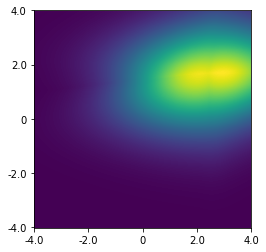

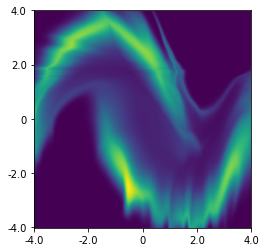

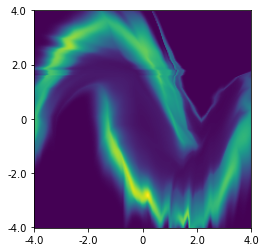

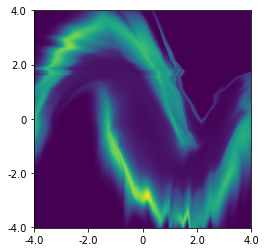

In [8]:
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(maf, opt, batch)

    if i % int(100) == 0:
        val_loss = nll(maf, val_data)
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i
            checkpoint.write(file_prefix=checkpoint_prefix)  # overwrite best val model

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

    if i % int(1000) == 0:
        # plot heatmap every 1000 epochs
        plot_heatmap_2d(maf, -4.0, 4.0, -4.0, 4.0, mesh_count=200)

train_time = time.time() - t_start

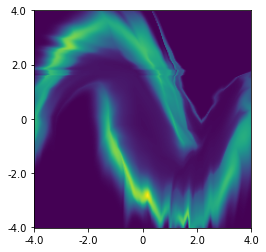

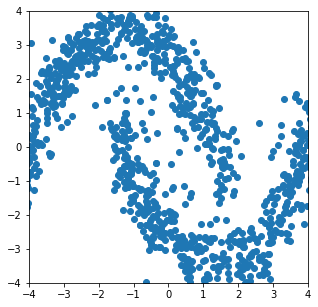

In [9]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()
test_loss = nll(maf, test_data)
test_time = time.time() - t_start

# plot density estimation of the best model
plot_heatmap_2d(maf, -4.0, 4.0, -4.0, 4.0, mesh_count=200, name=None)  # to save the image, specify a directory as name

# plot samples of the best model
plot_samples_2d(maf.sample(1000), name=None)  # to save the image, specify a directory as name

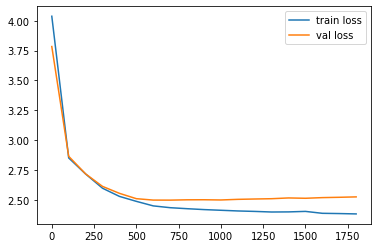

In [10]:
# plot train and validation loss curve
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.legend()

## 4. Sanity Check
On 2D toy data, a sanity check can be performed. The sanity check approximates the integral of the probability density function on the specified area. The approxmiated integral should be close to 1.

In [11]:
integral = sanity_check(maf, xmin=-4.0, xmax=4.0, ymin=-4.0, ymax=4.0, mesh_count=250)
print(integral)

tf.Tensor(0.99189407, shape=(), dtype=float32)


## 5. Delete unnecessary checkpoints

In [12]:
filelist = [f for f in os.listdir(checkpoint_directory)]
for f in filelist:
    os.remove(os.path.join(checkpoint_directory, f))
os.removedirs(checkpoint_directory)